<a href="https://colab.research.google.com/github/ChiaoYunTing/Text-Analytics/blob/main/Lecture_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning with Text
In this session, we will demonstrate how to perform predictive modeling with text data. We will use the `sms_spam.csv` dataset to analyze and predict whether an SMS is spam or not. We will explore three different approaches to achieve this:
1.	Create word tokens and use TF-IDF values to capture the essence of the text, and use these to predict the outcome.
2. Compute sentiment of the text, and use the sentiment captured in the text to predict the outcome.
3.	Use topic modeling to identify k topics, and use the percentage of each topic captured in the text to predict the outcome.

In a later session, we will also explore using word embeddings for predictive purposes.


In [1]:
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Read the file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# upload files using file picker
from google.colab import files
files.upload()

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/sms_spam.csv')

In [4]:
df

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will Ã¼ b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


## Preprocess

In [5]:
# Put it all into a function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    return ' '.join(tokens)



In [6]:
df['text'] = df['text'].apply(preprocess_text)

In [7]:
df

,type,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts may...
3,ham,u dun say early hor u c already say
4,ham,nah think goes usf lives around though
...,...,...
5569,spam,time tried contact u pound prize claim easy ca...
5570,ham,b going esplanade fr home
5571,ham,pity mood suggestions
5572,ham,guy bitching acted like interested buying some...


##TF-IDF
We will use the 100 most important terms, write them out to the file, and build a prediction model using random forest algorithm.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

##Compute tf-idf and predict based on these

Confusion Matrix:
 [[936  18]
 [ 25 136]]


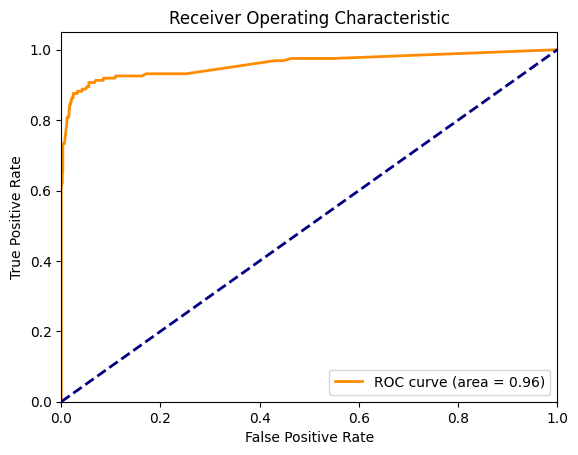

Feature ranking:
1. embedding 7 (0.151948)
2. embedding 87 (0.111749)
3. embedding 19 (0.064979)
4. embedding 10 (0.058615)
5. embedding 49 (0.056306)
6. embedding 77 (0.041215)
7. embedding 65 (0.040478)
8. embedding 67 (0.039692)
9. embedding 81 (0.037569)
10. embedding 95 (0.035096)
11. embedding 9 (0.030640)
12. embedding 88 (0.022712)
13. embedding 72 (0.021020)
14. embedding 55 (0.018070)
15. embedding 63 (0.014365)
16. embedding 20 (0.011785)
17. embedding 93 (0.010520)
18. embedding 47 (0.008683)
19. embedding 45 (0.008483)
20. embedding 18 (0.008249)
21. embedding 37 (0.008077)
22. embedding 75 (0.007474)
23. embedding 22 (0.007404)
24. embedding 61 (0.007217)
25. embedding 35 (0.007097)
26. embedding 14 (0.006181)
27. embedding 84 (0.005917)
28. embedding 90 (0.005810)
29. embedding 71 (0.005742)
30. embedding 51 (0.005134)
31. embedding 6 (0.005058)
32. embedding 64 (0.005048)
33. embedding 30 (0.004959)
34. embedding 25 (0.004739)
35. embedding 57 (0.004722)
36. embedding 4

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np


# Prepare the data using the correct TF-IDF features
# only take the most important 100 words
vectorizer_corrected = TfidfVectorizer(max_features=100)
tfidf_matrix_corrected = vectorizer_corrected.fit_transform(df['text'])
tfidf_df_corrected = pd.DataFrame(tfidf_matrix_corrected.toarray(), columns=vectorizer_corrected.get_feature_names_out())
df_corrected = pd.concat([df.drop(columns=['text']), tfidf_df_corrected], axis=1)  # Exclude original 'text' column for modeling

# Prepare the data for modeling
X = df_corrected.drop(columns=['type'])  # Features
y = df_corrected['type']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fill NaN values with zeros (common practice in TF-IDF where NaN signifies no occurrence of the term)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)


# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob,pos_label='spam')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. embedding %d (%f)" % (f + 1, indices[f], importances[indices[f]]))



In [10]:
df_corrected

,type,already,also,amp,anything,ask,babe,back,call,care,...,want,wat,way,week,well,win,work,would,yeah,yes
0,ham,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.54817,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,ham,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,spam,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.576455,0.0,0.0,0.0,0.0
3,ham,0.446435,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,ham,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,spam,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.37138,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
5570,ham,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
5571,ham,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
5572,ham,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.00000,0.0,0.526256,0.0,0.000000,0.0,0.0,0.0,0.0


## VADER Sentiment
Compute VADER sentiment and write it to the data frame.

In [11]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score for each text
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply the function to get sentiment score for each message in the DataFrame
df['vader_sentiment'] = df['text'].apply(get_sentiment)

# Display the first few rows to verify sentiment scores
df[['text', 'vader_sentiment']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,text,vader_sentiment
0,go jurong point crazy available bugis n great ...,0.4019
1,ok lar joking wif u oni,0.4767
2,free entry wkly comp win fa cup final tkts may...,0.7964
3,u dun say early hor u c already say,0.0000
4,nah think goes usf lives around though,-0.1027


### Prediction Model

Confusion Matrix:
 [[818 136]
 [125  36]]


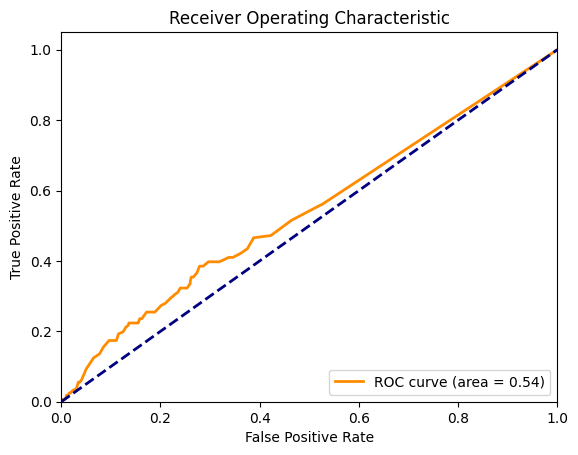

Feature ranking:
1. embedding 0 (1.000000)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Example setup: Assume 'vader_sentiment' column exists in df
# Create sample sentiment data for demonstration (normally you would have real scores here)
import numpy as np
df['vader_sentiment'] = np.random.rand(df.shape[0])  # Random scores for illustration

# Prepare the data for modeling
X = df[['vader_sentiment']]  # Predictor
y= df['type']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob,pos_label='spam')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. embedding %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


## Topic Modeling
We use LDA to create 10 topics and write them out to the data frame.

In [13]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

###LDA

In [14]:
# Assuming the text is preprocessed and stored as a list of words in df['text_preprocessed']
# If df['text'] is a single string of words, split it into lists
if isinstance(df['text'].iloc[0], str):
    df['text_preprocessed'] = df['text'].apply(lambda x: x.split())

# Create a Dictionary and Corpus from the preprocessed text
id2word_preprocessed = corpora.Dictionary(df['text_preprocessed'])
corpus_preprocessed = [id2word_preprocessed.doc2bow(text) for text in df['text_preprocessed']]

# Step 2: Initialize and fit the LDA model
lda_model_preprocessed = LdaModel(corpus=corpus_preprocessed, id2word=id2word_preprocessed, num_topics=10, random_state=42, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# Step 3: Extract Topic Distributions
topic_distributions_preprocessed = [lda_model_preprocessed.get_document_topics(bow) for bow in corpus_preprocessed]

# Normalize topic distributions and ensure each document has distribution over all 10 topics
def normalize_topic_distributions(distributions, num_topics=10):
    normalized = []
    for dist in distributions:
        doc_topics = dict(dist)
        normalized.append([doc_topics.get(i, 0) for i in range(num_topics)])
    return normalized

# Normalize topic distributions
normalized_topics_preprocessed = normalize_topic_distributions(topic_distributions_preprocessed)

# Create DataFrame with topic distributions
topics_df_preprocessed = pd.DataFrame(normalized_topics_preprocessed, columns=[f"Topic{i+1}" for i in range(10)])

# Concatenate original DataFrame with topics DataFrame
df_with_topics_gensim_preprocessed = pd.concat([df, topics_df_preprocessed], axis=1)

# Display the DataFrame with topics
df_with_topics_gensim_preprocessed.head()


,type,text,vader_sentiment,text_preprocessed,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,ham,go jurong point crazy available bugis n great ...,0.898873,"[go, jurong, point, crazy, available, bugis, n...",0.000000,0.000000,0.000000,0.000000,0.000000,0.648002,0.313113,0.000000,0.000000,0.000
1,ham,ok lar joking wif u oni,0.672776,"[ok, lar, joking, wif, u, oni]",0.014509,0.018814,0.010632,0.593157,0.013216,0.011514,0.308938,0.010747,0.000000,0.000
2,spam,free entry wkly comp win fa cup final tkts may...,0.964406,"[free, entry, wkly, comp, win, fa, cup, final,...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.963456,0.000
3,ham,u dun say early hor u c already say,0.412562,"[u, dun, say, early, hor, u, c, already, say]",0.010082,0.013072,0.000000,0.000000,0.000000,0.153807,0.779640,0.000000,0.000000,0.000
4,ham,nah think goes usf lives around though,0.526692,"[nah, think, goes, usf, lives, around, though]",0.012655,0.016398,0.000000,0.000000,0.198846,0.010043,0.011900,0.188470,0.000000,0.536


###Predict and Compute Performance Metrics

Confusion Matrix:
 [[934  20]
 [ 48 113]]


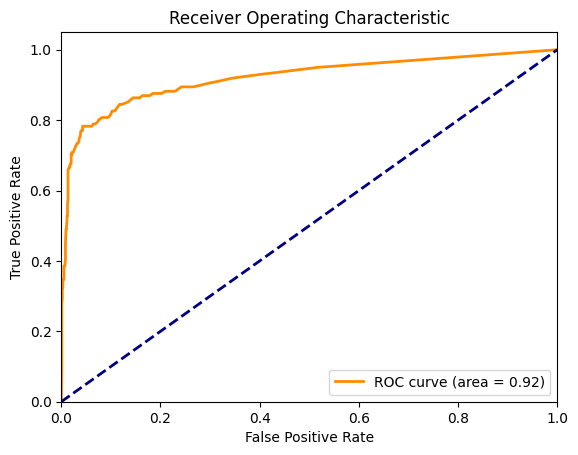

,Feature,Importance
1,Topic2,0.220804
8,Topic9,0.187389
0,Topic1,0.152894
6,Topic7,0.099744
4,Topic5,0.096845
5,Topic6,0.071946
2,Topic3,0.066992
3,Topic4,0.052372
7,Topic8,0.051014


In [15]:
# Prepare the data for modeling, excluding one topic for independence
X = df_with_topics_gensim_preprocessed[[f"Topic{i+1}" for i in range(9)]]  # Using Topic1 to Topic9
y = df_with_topics_gensim_preprocessed['type']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate ROC curve and AUC if both classes are present in the test set
if len(np.unique(y_test)) > 1:
    y_prob = rf_classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='spam')
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve not plotted. The test set does not contain both classes.")

# Feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances


# Your Turn
1.	 Read the `Roomba.csv` file. Create a new variable called `rating` which has values `high` and `low`. If the `Stars` value is 4 or 5, then `rating` should be `high`, otherwise `low`. Build models to predict `rating` based on `Review`. Conduct topic modeling (10 topics) and sentiments of `Review` and use these to predict  `rating`.

2.	Read the `imdb.csv` file and predict the sentiment based on the review of the movie.


## imdb

In [ ]:
df = pd.read_csv('imdb.csv')